In [55]:
from pytc2.sistemas_lineales import plot_plantilla
import pytc2.filtros_digitales

import pytc2

import numpy as np
from scipy import signal as sig
from scipy import interpolate

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

In [56]:
#%% Señal ECG

fs_ecg = 1000 # Hz

##################
## ECG con ruido
##################x

#para listar las variables que hay en el archivo
sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead'].flatten()

# plt.figure(1)
# plt.plot(ecg_one_lead[5000:12000])
# plt.show()

##################
## ECG sin ruido
##################

# Variables
qrs_pattern = mat_struct['qrs_pattern1'].flatten()
heartbeat_normal = mat_struct['heartbeat_pattern1'].flatten()
heartbeat_ventricular = mat_struct['heartbeat_pattern2'].flatten()
qrs_det = mat_struct['qrs_detections'].flatten()

N = len(ecg_one_lead)

ecg_one_lead = ecg_one_lead / np.std(ecg_one_lead)
ecg_signal = ecg_one_lead / np.std(ecg_one_lead)
heartbeat_normal = heartbeat_normal / np.std(heartbeat_normal)
heartbeat_ventricular = heartbeat_ventricular / np.std(heartbeat_ventricular)
qrs_pattern = qrs_pattern / np.std(qrs_pattern)

## Filtro de mediana

In [57]:
from scipy.signal import medfilt

#venetanas

win1_samples = 200
win2_samples = 600

#Paridad. Si es par le sumo 1
if win1_samples % 2 == 0:
    win1_samples += 1
if win2_samples % 2 == 0:
    win2_samples += qrs_pattern
    
#Primer filtro mediana
ecg_med1 = medfilt(ecg_signal, kernel_size = win1_samples)

#Segundo filtro de mediana
ecg_med2 = medfilt(ecg_med1, kernel_size = win1_samples)

ecg_filt_med = ecg_signal - ecg_med2


Mediana - primeros valores de x̂ (filtrada), s (original) y b̂ (línea base):

Índice |    x̂ (Filtrada) |   s (Original)  |    b̂ (Línea de base)
-----------------------------------------------------------------
     0 |           0.000 |          -0.155 |               -0.155
     1 |           0.000 |          -0.180 |               -0.180
     2 |           0.000 |          -0.207 |               -0.207
     3 |           0.000 |          -0.232 |               -0.232
     4 |           0.000 |          -0.257 |               -0.257
     5 |           0.000 |          -0.282 |               -0.282
     6 |           0.000 |          -0.306 |               -0.306
     7 |           0.000 |          -0.331 |               -0.331
     8 |           0.000 |          -0.357 |               -0.357
     9 |           0.000 |          -0.384 |               -0.384
    10 |           0.000 |          -0.408 |               -0.408
    11 |           0.000 |          -0.431 |               -0

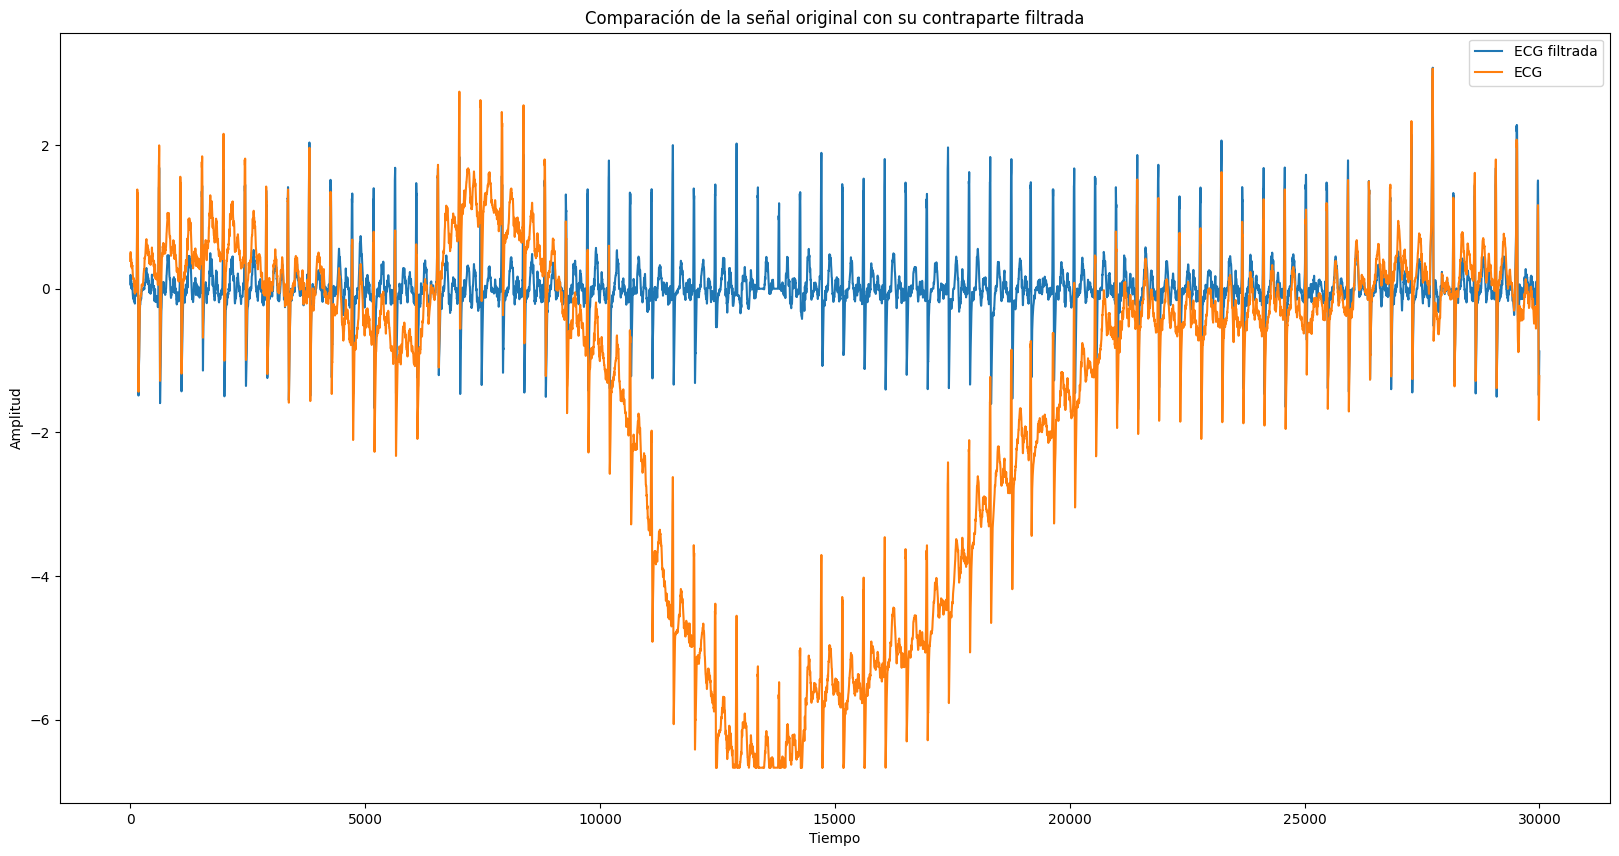

In [66]:
print("\nMediana - primeros valores de x̂ (filtrada), s (original) y b̂ (línea base):\n")

print(f"{'Índice':>6} |   {'x̂ (Filtrada)':^15}|  {'s (Original)':^15}|    {'b̂ (Línea de base)'}")
print("-" * 65)

# Mostrar los primeros 20 valores
for i in range(20):
    print(f"{i:6d} | {ecg_filt_med[i]:15.3f} | {ecg_signal[i]:15.3f} | {ecg_med2[i]:20.3f}")

plt.figure(figsize=(20,10))
plt.plot(ecg_filt_med[720000:750000], label = 'ECG filtrada')
plt.plot(ecg_signal[720000:750000], label = 'ECG')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Comparación de la señal original con su contraparte filtrada')
plt.legend()
plt.show()

## Spline cúbico

In [59]:
N_ecg = len(ecg_one_lead)
t_ecg = np.arange(N_ecg) / fs_ecg  # eje de tiempo en segundos


def estimate_baseline_spline(ecg_sig, qrs_det, fs, n0_ms, window_ms):
     
    n0 = int(n0_ms * fs / 1000)          # conversión ms a muestras
    window = int(window_ms * fs / 1000)  # ventana en muestras
    
    t_ecg = np.arange(len(ecg_sig)) / fs
    baseline_times = [] #tiempos de los puntos fiduciales usados para la spline
    baseline_values = [] #valores promedio en esos puntos

    for qrs in qrs_det:
        idx = qrs - n0
        if idx - window//2 < 0 or idx + window//2 >= len(ecg_sig):
            continue  # evitamos salirnos del vector

        window_data = ecg_signal[idx - window//2 : idx + window//2]
        baseline_times.append(t_ecg[idx])
        baseline_values.append(np.mean(window_data))
        
    spline_func = interpolate.CubicSpline(baseline_times, baseline_values)
    baseline = spline_func(t_ecg) #línea de base interpolada
    return baseline, baseline_times, baseline_values

# Estimamos línea de base usando spline cúbica
baseline_full, base_times, base_vals = estimate_baseline_spline(ecg_signal, qrs_det, fs=fs_ecg, n0_ms=100, window_ms=20) #Estima la línea de base de una señal ECG usando spline cúbica
ecg_clean_full = ecg_signal - baseline_full



Mediana - primeros valores de x̂ (filtrada), s (original) y b̂ (línea base):

Índice |    x̂ (Filtrada) |   s (Original)  |    b̂ (Línea de base)
-----------------------------------------------------------------
     0 |           0.854 |          -0.155 |               -1.009
     1 |           0.827 |          -0.180 |               -1.008
     2 |           0.801 |          -0.207 |               -1.007
     3 |           0.775 |          -0.232 |               -1.007
     4 |           0.749 |          -0.257 |               -1.006
     5 |           0.724 |          -0.282 |               -1.006
     6 |           0.699 |          -0.306 |               -1.005
     7 |           0.673 |          -0.331 |               -1.004
     8 |           0.646 |          -0.357 |               -1.004
     9 |           0.620 |          -0.384 |               -1.003
    10 |           0.594 |          -0.408 |               -1.003
    11 |           0.571 |          -0.431 |               -1

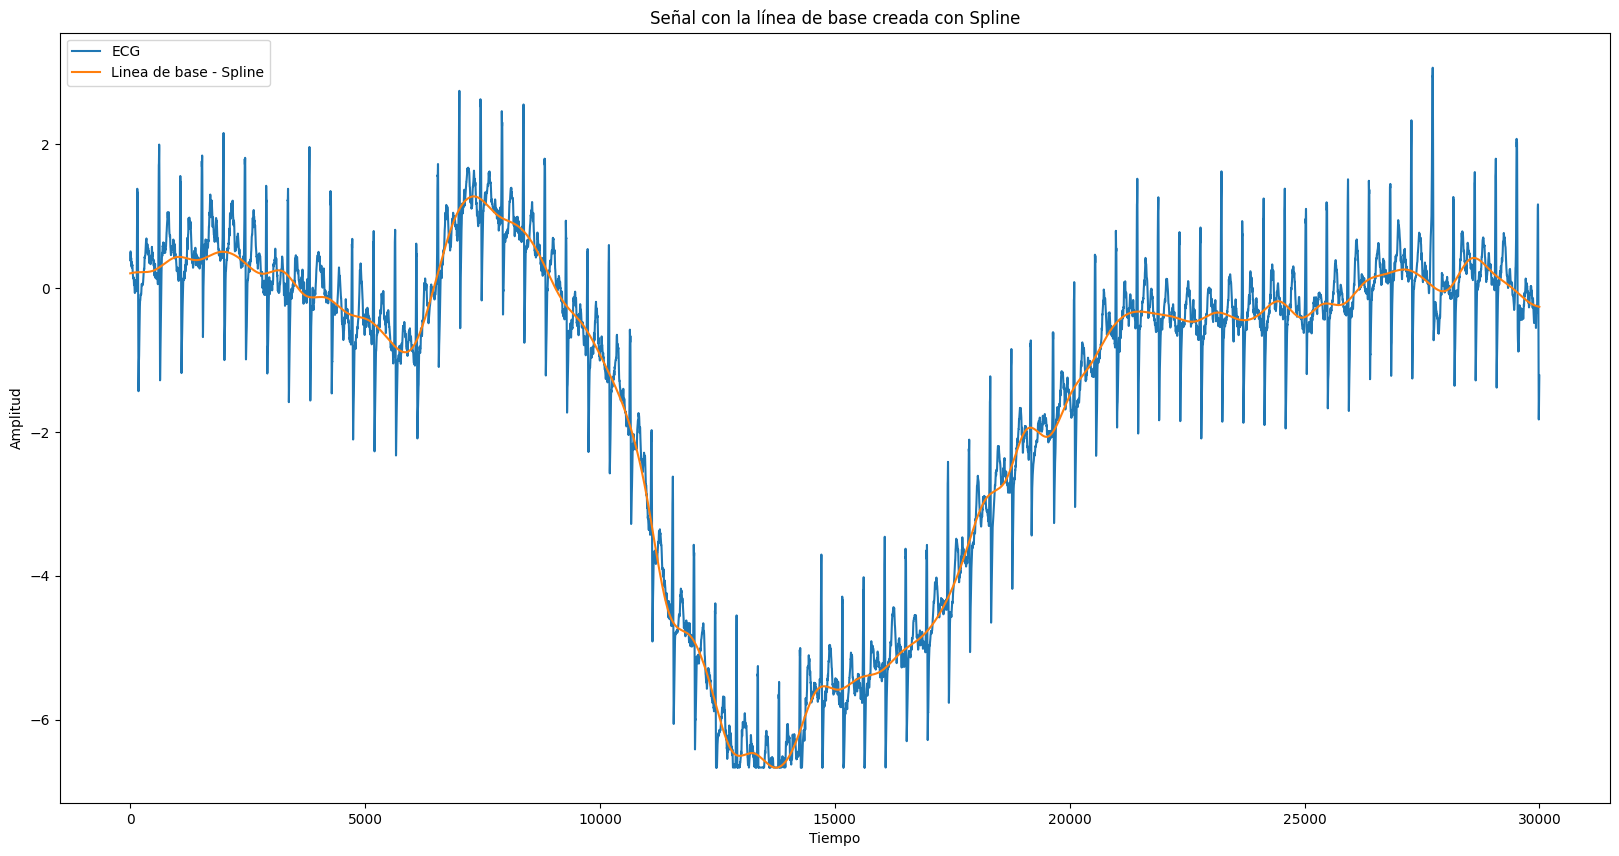

In [67]:
print("\nMediana - primeros valores de x̂ (filtrada), s (original) y b̂ (línea base):\n")

print(f"{'Índice':>6} |   {'x̂ (Filtrada)':^15}|  {'s (Original)':^15}|    {'b̂ (Línea de base)'}")
print("-" * 65)

# Mostrar los primeros 20 valores
for i in range(20):
    print(f"{i:6d} | {ecg_clean_full[i]:15.3f} | {ecg_signal[i]:15.3f} | {baseline_full[i]:20.3f}")

plt.figure(figsize=(20,10))
plt.plot(ecg_signal[720000:750000], label = 'ECG')
plt.plot(baseline_full[720000:750000], label = 'Linea de base - Spline')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Señal con la línea de base creada con Spline')
plt.legend()
plt.show()

## Filtro adaptado

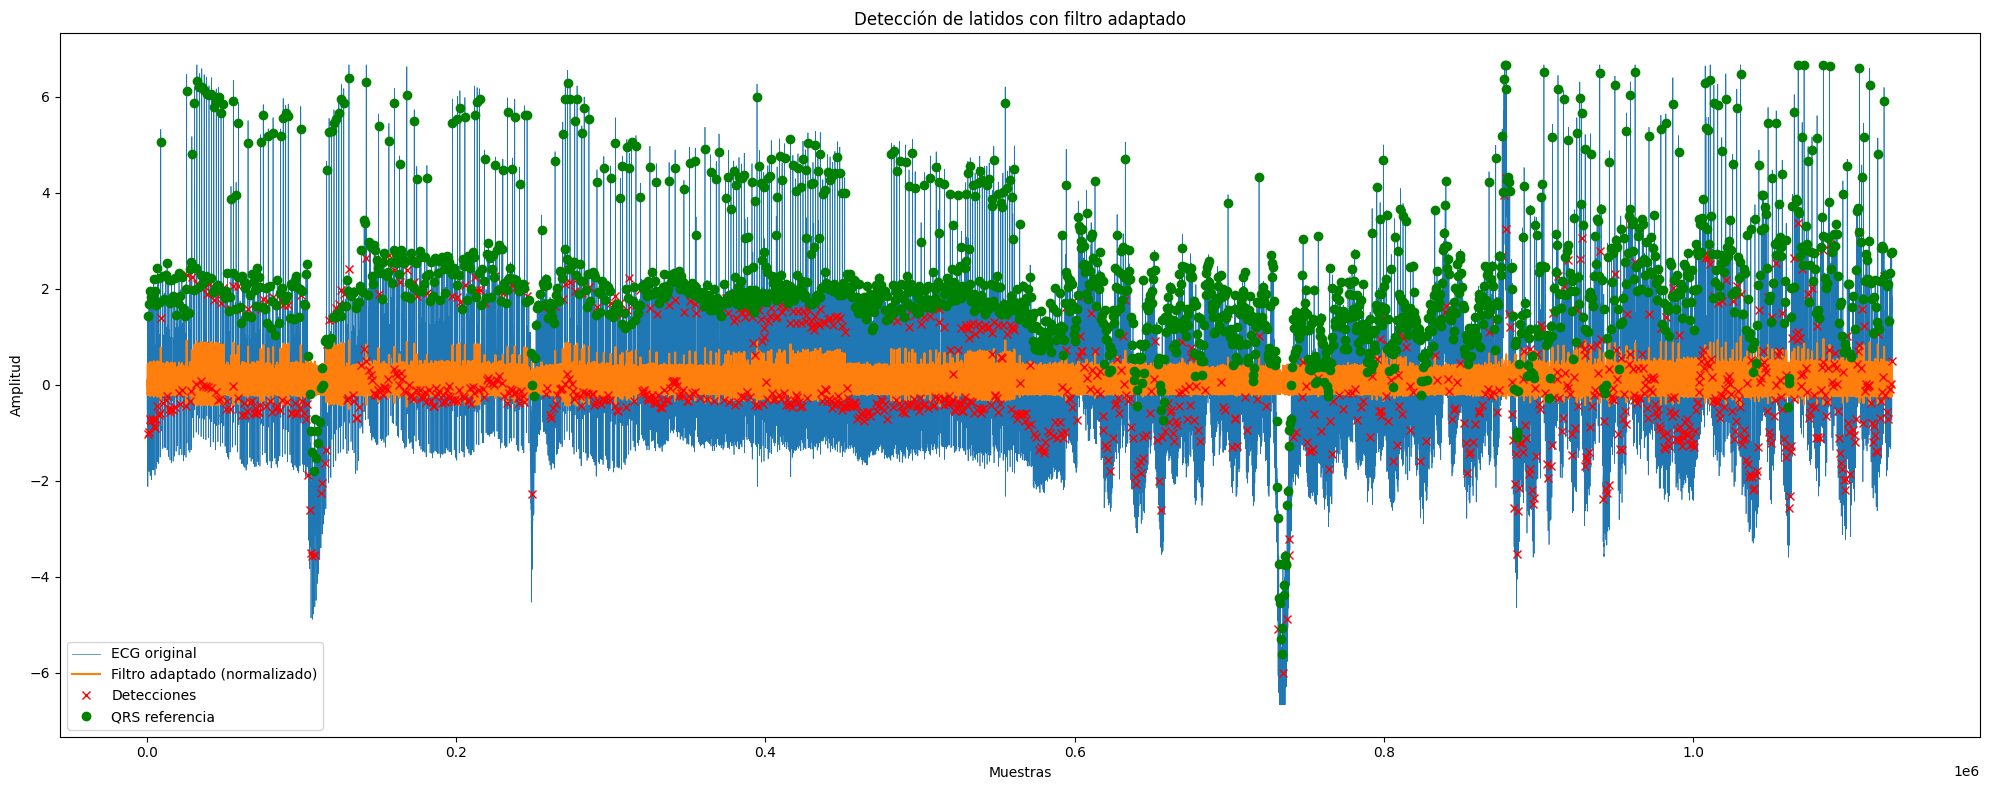

In [61]:
# Centrar señal y patrón para eliminar defasaje
ecg_centered = ecg_signal - np.mean(ecg_signal)
pattern_centered = qrs_pattern[::-1] - np.mean(qrs_pattern)

# Matched filter
filtered_signal = np.convolve(ecg_centered, pattern_centered, mode='same')

#  Detección de picos en señal filtrada 
height_threshold = np.max(filtered_signal) * 0.4
distance_threshold = int(fs_ecg * 0.3)
peaks, _ = sig.find_peaks(filtered_signal, height=height_threshold, distance=distance_threshold)

# Comparación detección con referencia
tolerance = int(0.05 * fs_ecg)
TP = 0 #True Positive
FP = 0 #False Positive

detected = np.zeros(len(qrs_det), dtype=bool)

for p in peaks:
    match = False
    for i, qrs in enumerate(qrs_det):
        if not detected[i] and abs(p - qrs) <= tolerance:
            TP += 1
            detected[i] = True
            match = True
            break
    if not match:
        FP += 1

FN = len(qrs_det) - TP
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

#  Resultados detección 
plt.figure(figsize=(20, 8))
plt.plot(ecg_signal, label='ECG original', linewidth=0.5)
plt.plot(filtered_signal / np.max(filtered_signal), label='Filtro adaptado (normalizado)')
plt.plot(peaks, ecg_signal[peaks], 'rx', label='Detecciones')
plt.plot(qrs_det, ecg_signal[qrs_det], 'go', label='QRS referencia')
plt.legend()
plt.title("Detección de latidos con filtro adaptado")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.tight_layout()
plt.show()

### a)

El filtro adaptado se aprovecha de correlacionar una señal retardada conocida, que haría la función de plantilla, con una señal que se desconoce, a fin de detectar la presencia de los patrones caracteristicos de la primera, la "plantilla". Esto es el equivalente a convolucionar esa señal desconocida con una version conjugada e invertida en el tiempo de esa plantilla. En última instancia, se logra maximizar la relacion señal-ruido (SNR) en presencia de ruido estocastico aditivo.
En el caso concreto que nos compete, qrs_pattern, contiene esa "plantilla" con la forma típica del complejo QRS del ECG. Así, al aplicar el filtro adaptado sobre la señal, se consigue realzar dichos lugares y facilitar la detección de los picos.

Sin embargo, debido a las varaiciones que se pueden presentar en el complejo QRS, por un incremento de actividad o condiciones adversas de la persona, el patron de qrs_pattern podría no servirnos o jugarnos en contra.

### b)

In [62]:
print(f"Verdaderos positivos: {TP}")
print(f"Falsos positivos: {FP}")
print(f"Falsos negativos: {FN}")
print(f"Sensibilidad: {sensitivity*100:.2f}%")
print(f"Precisión: {precision*100:.2f}%")

Verdaderos positivos: 1147
Falsos positivos: 0
Falsos negativos: 756
Sensibilidad: 60.27%
Precisión: 100.00%
